In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kkanghyewon","key":"d740baba09e42bfce33b88d168228363"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/hippocampus-segmentation-in-mri-images
!unzip -qq hippocampus-segmentation-in-mri-images.zip

 98% 793M/806M [00:05<00:00, 154MB/s]
100% 806M/806M [00:05<00:00, 165MB/s]


# preprocessing

In [5]:
pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 144 kB/s 


In [6]:
import nibabel as nib
import cv2 
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import backend as K

In [7]:
# 1. image path load
import glob

train_img_path = sorted(glob.glob('/content/Train/*.img'))
train_hdr_path = sorted(glob.glob('/content/Train/*.hdr'))
train_img_label = sorted(glob.glob('/content/Train/Labels/*.img'))
train_hdr_label = sorted(glob.glob('/content/Train/Labels/*.hdr'))

train_data_path = train_img_path + train_hdr_path
train_label_path = train_img_label + train_hdr_label
train_img_num = len(train_data_path)

test_img_path = sorted(glob.glob('/content/Test/*.img'))
test_hdr_path = sorted(glob.glob('/content/Test/*.hdr'))

test_img_path = test_img_path[4], test_img_path[14] , test_img_path[24]
test_hdr_path = test_hdr_path[4] , test_hdr_path[14] , test_hdr_path[24]

- no.30 - 124 slide
- no.40 - 108 slide
- no.50 - 86  slide

In [11]:
# # 2-1. train_data)  1.label에 값 있는 것만 골라오기 /  2.resize
train_img_arr = np.ndarray([train_img_num*124,256,256], dtype="float32")
train_label1_arr = np.ndarray([train_img_num*124,256,256,1], dtype="uint8")
train_label2_arr = np.ndarray([train_img_num*124,256,256,1], dtype="uint8")
num = 0

for i in range(train_img_num):
  label_sitk = sitk.ReadImage(train_label_path[i], sitk.sitkUInt8)
  label_dummys = sitk.GetArrayFromImage(label_sitk)
  label_dummys = np.transpose(label_dummys, (0, 2, 1))
  dummys_slide_num = label_dummys.shape[2]

  for j in range(dummys_slide_num):
    check_value = np.sum(np.unique(label_dummys[:,:,j]))  #  hippocampus가 있는지 확인

    if check_value != 0:
      # image
      img_sitk = sitk.ReadImage(train_data_path[i], sitk.sitkFloat32)
      img_dummys = sitk.GetArrayFromImage(img_sitk)
      img_dummys = np.transpose(img_dummys, (0, 2, 1))

      train_img_arr[num] = cv2.resize(img_dummys[:,:,j], (256,256), interpolation=cv2.INTER_LINEAR).astype("float32")

      # label
      label_1 = ((label_dummys[:,:,j]) == 1) * 1
      train_label1_arr[num] = np.resize(label_1, (256,256,1)).astype("uint8")

      label_2 = ((label_dummys[:,:,j]) == 2) * 1
      train_label2_arr[num] = np.resize(label_2, (256,256,1)).astype("uint8")

      num += 1

num_train_data = num
train_img_arr = train_img_arr[:num_train_data]
train_label1_arr = train_label1_arr[:num_train_data]
train_label2_arr = train_label2_arr[:num_train_data]
train_label_arr = np.concatenate((train_label1_arr, train_label2_arr), axis=3)

In [14]:
print(train_img_arr.shape, train_label1_arr.shape, train_label2_arr.shape, train_label_arr.shape)

(918, 256, 256) (918, 256, 256, 1) (918, 256, 256, 1) (918, 256, 256, 2)


In [9]:
# 2-2.  test_data - only three case
test_img_arr = np.ndarray([3*124,256,256], dtype="float32")
num = 0

for i in range(len(test_img_path)):
  img_sitk = sitk.ReadImage(test_img_path[i], sitk.sitkFloat32)

  img_dummys = sitk.GetArrayFromImage(img_sitk)
  img_dummys = np.transpose(img_dummys, (0, 2, 1))
  dummys_slide_num = img_dummys.shape[2]

  for j in range(dummys_slide_num):
    test_img_arr[num] = cv2.resize(img_dummys[:,:,j], (256,256), interpolation=cv2.INTER_LINEAR  ).astype("float32")
    num += 1

num_test_img = num
test_img_arr = test_img_arr[:num_test_img]

In [10]:
# 2-2.  test_data - only three case 
test_hdr_arr = np.ndarray([3*124,256,256], dtype="float32")
num = 0

for i in range(len(test_hdr_path)):
  img_sitk = sitk.ReadImage(test_hdr_path[i], sitk.sitkFloat32)

  img_dummys = sitk.GetArrayFromImage(img_sitk)
  img_dummys = np.transpose(img_dummys, (0, 2, 1))
  dummys_slide_num = img_dummys.shape[2]

  for j in range(dummys_slide_num):
    test_hdr_arr[num] = cv2.resize(img_dummys[:,:,j], (256,256), interpolation=cv2.INTER_LINEAR  ).astype("float32")
    num += 1

num_test_hdr = num
test_hdr_arr = test_hdr_arr[:num_test_hdr]

In [15]:
# 3. train / validation split
val_num = 180

train_data =  train_img_arr[:-val_num]
val_data = train_img_arr[-val_num:]

train_label = train_label_arr[:-val_num]
val_label = train_label_arr[-val_num:]

test_img = test_img_arr
test_hdr = test_hdr_arr

In [18]:
print(train_data.shape,  train_label.shape)
print(val_data.shape,  val_label.shape)
print(test_img.shape,  test_hdr.shape)

(738, 256, 256) (738, 256, 256, 2)
(180, 256, 256) (180, 256, 256, 2)
(318, 256, 256) (318, 256, 256)


In [19]:
# 4. scaling - fit
mean_v = train_data.mean()
std_v =  train_data.std()


# transform
train_data -= mean_v
train_data /= std_v

val_data -= mean_v
val_data /= std_v

test_img -= mean_v
test_img /= std_v

test_hdr -= mean_v
test_hdr /= std_v

In [20]:
print(train_data.max(),  train_data.min())
print(val_data.max(),  val_data.min())
print(test_img.max(), test_img.min())
print(test_hdr.max(), test_hdr.min())

14.027416 -0.5796635
14.027416 -0.5796635
6.755381 -0.5796635
6.755381 -0.5796635


# Model

In [27]:
# model 1
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(256,256,1))

x = layers.Conv2D(16,3,strides=2, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(16,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(32,3,strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(32,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64,3,strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128,3,strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)


x = layers.Conv2DTranspose(128,3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      128,3, activation="relu", padding="same", strides=2)(x)

x = layers.Conv2DTranspose(64,3,activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      64,3, activation="relu", padding="same", strides=2)(x)

x = layers.Conv2DTranspose(32,3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      32,3, activation="relu", padding="same", strides=2)(x)

x = layers.Conv2DTranspose(16,3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      16,3, activation="relu", padding="same", strides=2)(x)

outputs = layers.Conv2D(2, 1, activation='sigmoid', padding="same")(x)
  
model = keras.Model(inputs, outputs=outputs)  
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 batch_normalization_24 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_25 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                          

In [35]:
import tensorflow 
import tensorflow as tf
from keras import backend as K


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath ='/content/drive/Shareddrives/dl/save/기말/20_model_two_label.h5',
        save_best_only = True,
        monitor = "val_loss"
    )
]


def iou_coef_l(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[0])
    union = K.sum(y_true,[0])+K.sum(y_pred,[0])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_r(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
    union = K.sum(y_true,[1])+K.sum(y_pred,[1])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, 
                                                epsilon=None, decay=0.0, amsgrad=False)

model.compile(
    loss=[tf.keras.losses.BinaryFocalCrossentropy()],
    optimizer=optimizer,
    metrics=[iou_coef_l, iou_coef_r],
)

In [36]:
history_1 = model.fit(x=train_data, y=train_label,
                      epochs=20,
                      validation_data=(val_data, val_label),
                      batch_size = 20,
                      callbacks=callbacks)

Epoch 1/20
37/37 [==============================] - 6s 100ms/step - loss: 4.2616e-04 - iou_coef_l: 0.9780 - iou_coef_r: 0.8621 - val_loss: 3.4484e-06 - val_iou_coef_l: 0.9972 - val_iou_coef_r: 0.9722
Epoch 2/20
37/37 [==============================] - 3s 83ms/step - loss: 3.1577e-04 - iou_coef_l: 0.9830 - iou_coef_r: 0.8904 - val_loss: 6.8954e-05 - val_iou_coef_l: 0.9848 - val_iou_coef_r: 0.9065
Epoch 3/20
37/37 [==============================] - 3s 81ms/step - loss: 3.1349e-04 - iou_coef_l: 0.9847 - iou_coef_r: 0.9015 - val_loss: 2.0163e-04 - val_iou_coef_l: 0.9299 - val_iou_coef_r: 0.7698
Epoch 4/20
37/37 [==============================] - 3s 87ms/step - loss: 2.9300e-04 - iou_coef_l: 0.9857 - iou_coef_r: 0.9063 - val_loss: 2.8359e-08 - val_iou_coef_l: 0.9997 - val_iou_coef_r: 0.9964
Epoch 5/20
37/37 [==============================] - 3s 83ms/step - loss: 2.5548e-04 - iou_coef_l: 0.9885 - iou_coef_r: 0.9236 - val_loss: 5.1748e-05 - val_iou_coef_l: 0.9900 - val_iou_coef_r: 0.9242
Epoc

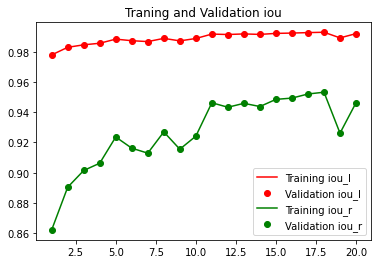

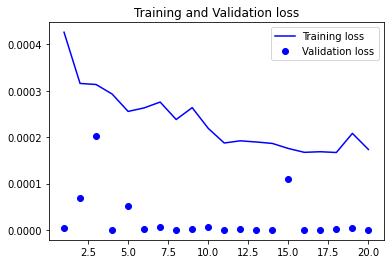

In [46]:
import matplotlib.pyplot as plt

iou_l = history_1.history["iou_coef_l"]
iou_r = history_1.history["iou_coef_r"]

val_iou_l =  history_1.history["iou_coef_l"]
val_iou_r =  history_1.history["iou_coef_r"]

loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]

epochs = range(1, len(iou_l) + 1)

plt.plot(epochs, iou_l, "r-", label="Training iou_l")
plt.plot(epochs, val_iou_l, "ro", label="Validation iou_l")
plt.plot(epochs, iou_r, "g-", label="Training iou_r")
plt.plot(epochs, val_iou_r, "go", label="Validation iou_r")
plt.title("Traning and Validation iou")
plt.legend()
plt.figure()


plt.plot(epochs, loss, "b-", label = "Training loss")
plt.plot(epochs, val_loss, "bo", label = "Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

- \
- \
- \
validation set도 포함하여 재학습
- 
- \
- \

In [84]:
train_data =  train_img_arr
train_label = train_label_arr

test_img = test_img_arr
test_hdr = test_hdr_arr

In [85]:
mean_v = train_data.mean()
std_v =  train_data.std()

# transform
train_data -= mean_v
train_data /= std_v

test_img -= mean_v
test_img /= std_v

test_hdr -= mean_v
test_hdr /= std_v

In [86]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(256,256,1))

x = layers.Conv2D(16,3,strides=2, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(16,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(32,3,strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(32,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64,3,strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128,3,strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128,3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)


x = layers.Conv2DTranspose(128,3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      128,3, activation="relu", padding="same", strides=2)(x)

x = layers.Conv2DTranspose(64,3,activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      64,3, activation="relu", padding="same", strides=2)(x)

x = layers.Conv2DTranspose(32,3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      32,3, activation="relu", padding="same", strides=2)(x)

x = layers.Conv2DTranspose(16,3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
      16,3, activation="relu", padding="same", strides=2)(x)

outputs = layers.Conv2D(2, 1, activation='sigmoid', padding="same")(x)
  
model_2 = keras.Model(inputs, outputs=outputs)  
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 batch_normalization_32 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_33 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                          

In [88]:
import tensorflow 
import tensorflow as tf
from keras import backend as K


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath ='/content/model_2.h5',
        save_best_only = True,
        monitor = "loss"
    )
]


def iou_coef_l(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[0])
    union = K.sum(y_true,[0])+K.sum(y_pred,[0])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_r(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
    union = K.sum(y_true,[1])+K.sum(y_pred,[1])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, 
                                                epsilon=None, decay=0.0, amsgrad=False)

model_2.compile(
    loss=[tf.keras.losses.BinaryFocalCrossentropy()],
    optimizer=optimizer,
    metrics=[iou_coef_l, iou_coef_r],
)

In [89]:
history_2 = model_2.fit(x=train_data, y=train_label,
                      epochs=100,
                      batch_size = 20,
                      callbacks=callbacks)

Epoch 1/100
46/46 [==============================] - 5s 81ms/step - loss: 0.0338 - iou_coef_l: 0.6777 - iou_coef_r: 0.3642
Epoch 2/100
46/46 [==============================] - 4s 77ms/step - loss: 0.0017 - iou_coef_l: 0.8856 - iou_coef_r: 0.6573
Epoch 3/100
46/46 [==============================] - 4s 87ms/step - loss: 0.0015 - iou_coef_l: 0.9076 - iou_coef_r: 0.7101
Epoch 4/100
46/46 [==============================] - 4s 85ms/step - loss: 0.0012 - iou_coef_l: 0.9203 - iou_coef_r: 0.7399
Epoch 5/100
46/46 [==============================] - 4s 87ms/step - loss: 0.0011 - iou_coef_l: 0.9320 - iou_coef_r: 0.7509
Epoch 6/100
46/46 [==============================] - 4s 92ms/step - loss: 9.9449e-04 - iou_coef_l: 0.9390 - iou_coef_r: 0.7691
Epoch 7/100
46/46 [==============================] - 4s 82ms/step - loss: 8.9460e-04 - iou_coef_l: 0.9497 - iou_coef_r: 0.7852
Epoch 8/100
46/46 [==============================] - 4s 78ms/step - loss: 8.2004e-04 - iou_coef_l: 0.9569 - iou_coef_r: 0.8080
Epoc

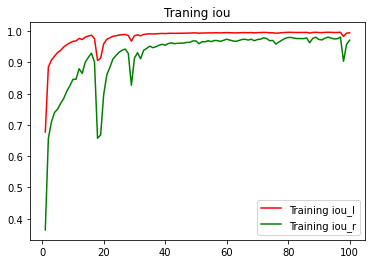

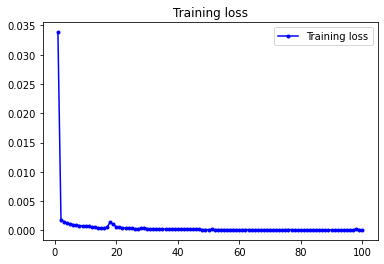

In [95]:
import matplotlib.pyplot as plt

iou_l = history_2.history["iou_coef_l"]
val_iou_l =  history_2.history["iou_coef_l"]
loss = history_2.history["loss"]

epochs = range(1, len(iou_l) + 1)

plt.plot(epochs, iou_l, "r-", label="Training iou_l")
plt.plot(epochs, iou_r, "g-", label="Training iou_r")
plt.title("Traning iou")
plt.legend()
plt.figure()


plt.plot(epochs, loss, "b.-", label = "Training loss")
plt.title("Training loss")
plt.legend()
plt.show()

# prediction

In [96]:
from tensorflow import keras

model = keras.models.load_model('/content/model_2.h5', custom_objects={"iou_coef_l": iou_coef_l, "iou_coef_r": iou_coef_r})

In [97]:
y_pred_img = model.predict(test_img)
y_pred_hdr = model.predict(test_hdr)

10/10 [==============================] - 0s 35ms/step


In [98]:
y_pred_img_scaled = (y_pred_img>0.1)*1
y_pred_img_scaled = y_pred_img_scaled.reshape(y_pred_img_scaled.shape[0],256,256,2)

y_pred_hdr_scaled = (y_pred_hdr>0.1)*1
y_pred_hdr_scaled = y_pred_hdr_scaled.reshape(y_pred_hdr_scaled.shape[0],256,256,2)

In [99]:
# img
test_img_30 = test_img[:124]
test_img_40 = test_img[124:232]
test_img_50 = test_img[232:]

y_pred_img_30 = y_pred_img_scaled[:124]
y_pred_img_40 = y_pred_img_scaled[124:232]
y_pred_img_50 = y_pred_img_scaled[232:]

# hde
test_hdr_30 = test_hdr[:124]
test_hdr_40 = test_hdr[124:232]
test_hdr_50 = test_hdr[232:]

y_pred_hdr_30 = y_pred_hdr_scaled[:124]
y_pred_hdr_40 = y_pred_hdr_scaled[124:232]
y_pred_hdr_50 = y_pred_hdr_scaled[232:]

30번 환자 img prediction


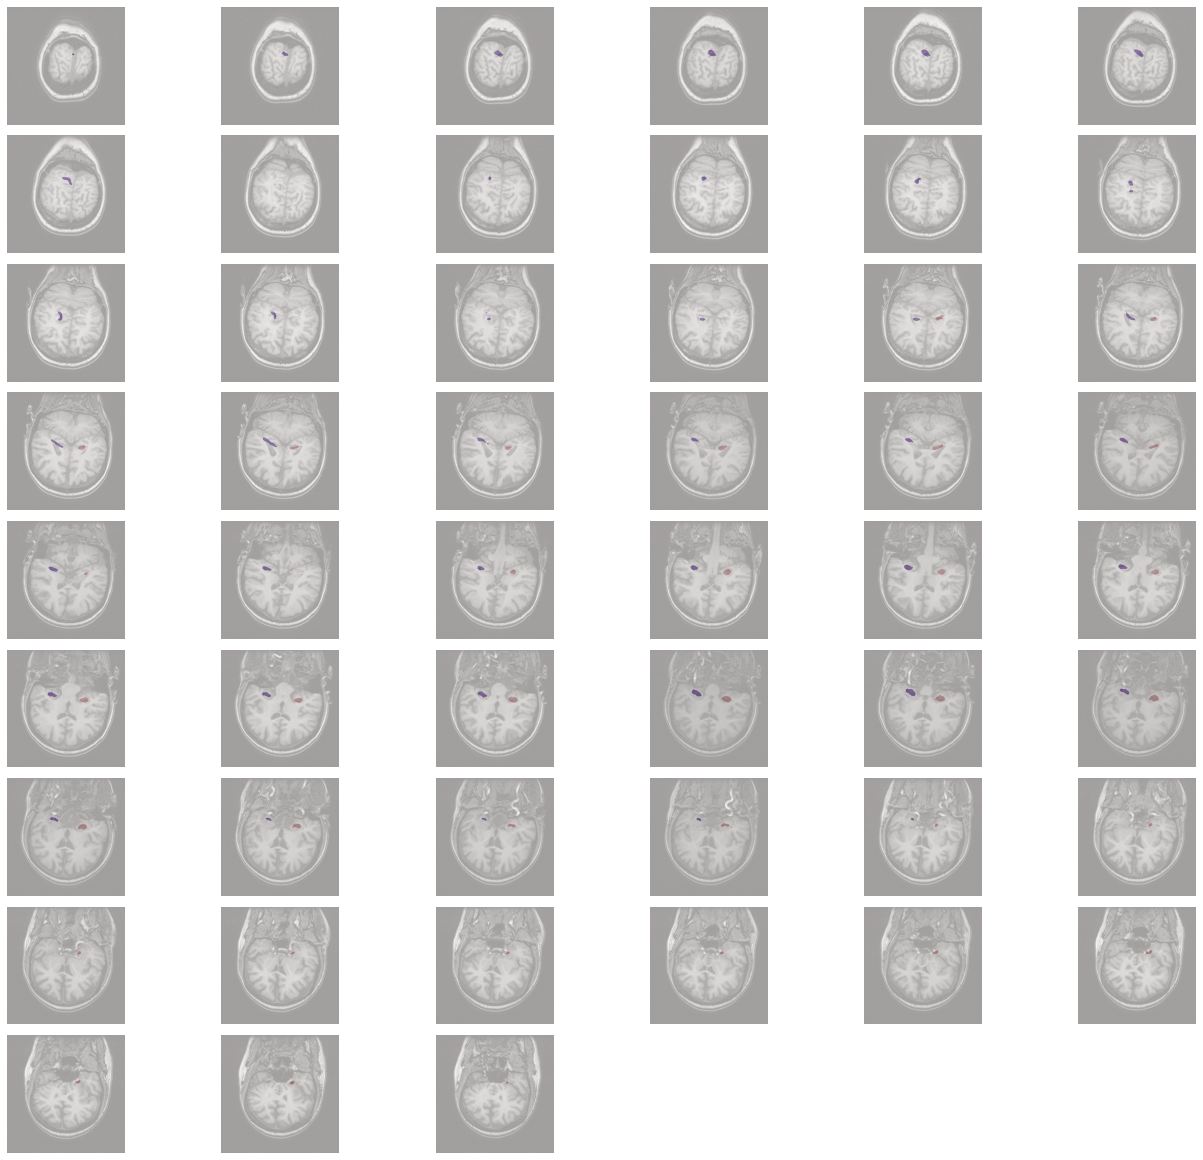

30번 환자 hdr prediction


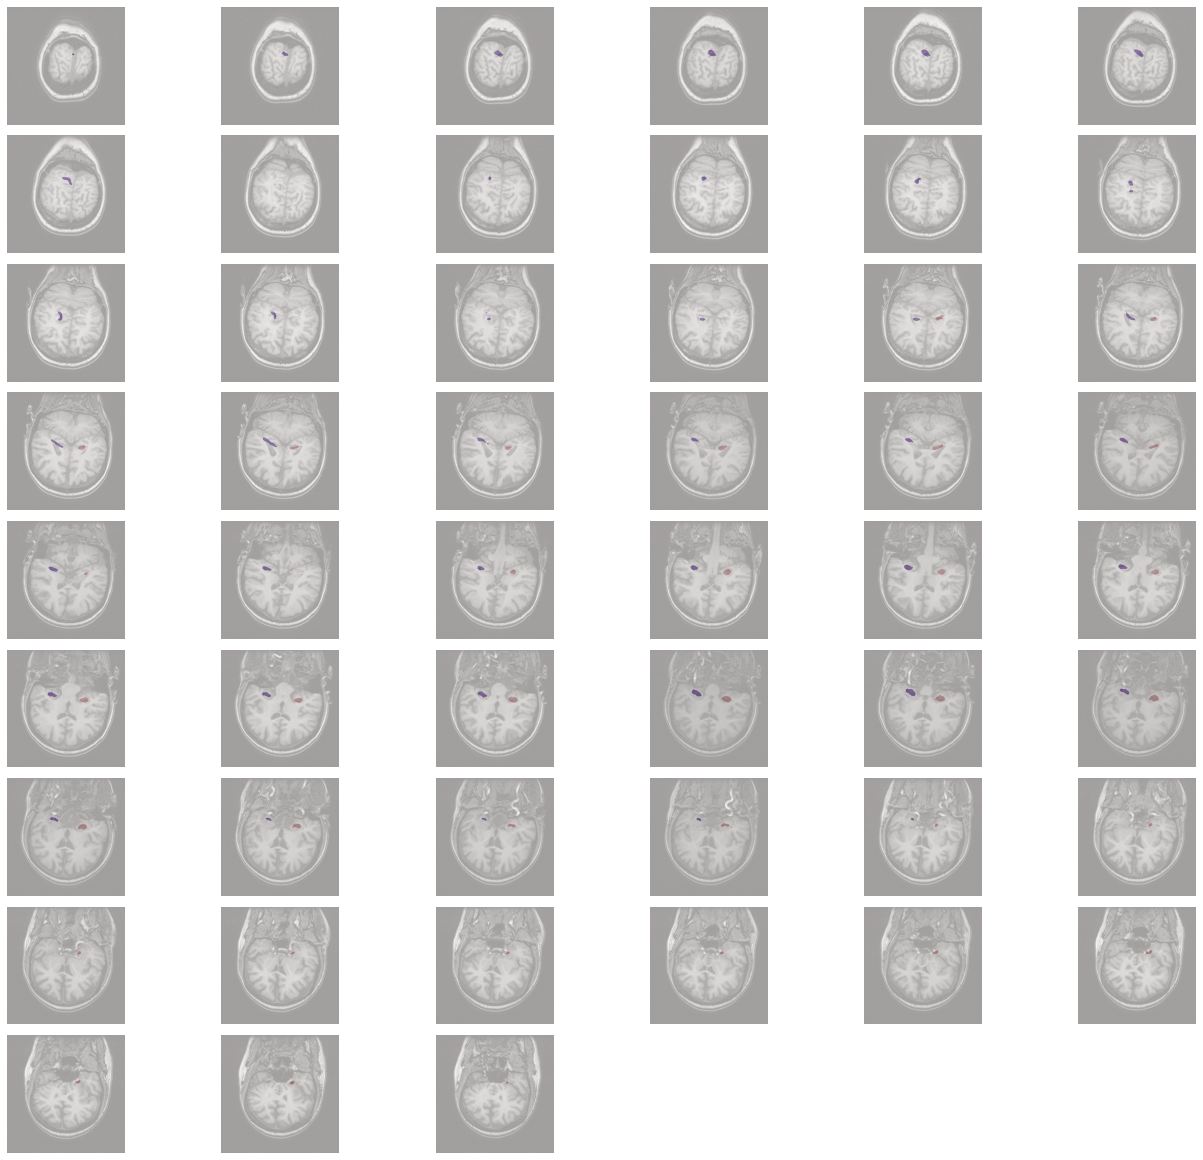

In [101]:
#
#
#   label 있는 것만 predict
#
#
print("30번 환자 img prediction")

index = 1
plt.figure(figsize=(18,18))

for i in range(len(test_img_30)): 
  if np.sum(np.unique(y_pred_img_30[i])) != 0:    
    plt.subplot(10,6,index)
    plt.imshow(test_img_30[i], cmap='gray')
    plt.imshow(y_pred_img_30[i][:,:,0], cmap='Reds', alpha=0.4)
    plt.imshow(y_pred_img_30[i][:,:,1], cmap='Purples', alpha=0.4)
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()


print("30번 환자 hdr prediction")

index = 1
plt.figure(figsize=(18,18))

for i in range(len(test_hdr_30)): 
  if np.sum(np.unique(y_pred_hdr_30[i])) != 0:    
    plt.subplot(10,6,index)
    plt.imshow(test_hdr_30[i], cmap='gray')
    plt.imshow(y_pred_hdr_30[i][:,:,0], cmap='Reds', alpha=0.4)
    plt.imshow(y_pred_hdr_30[i][:,:,1], cmap='Purples', alpha=0.4)
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()   

40번 환자 img prediction


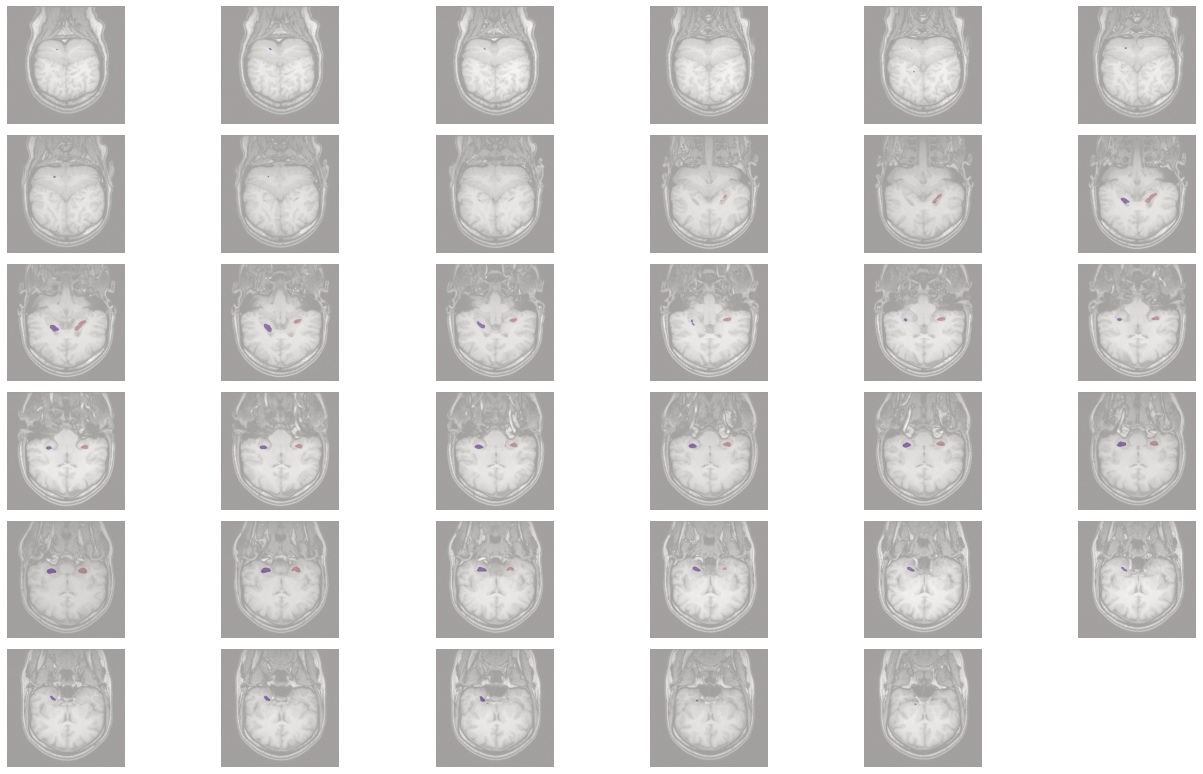

40번 환자 hdr prediction


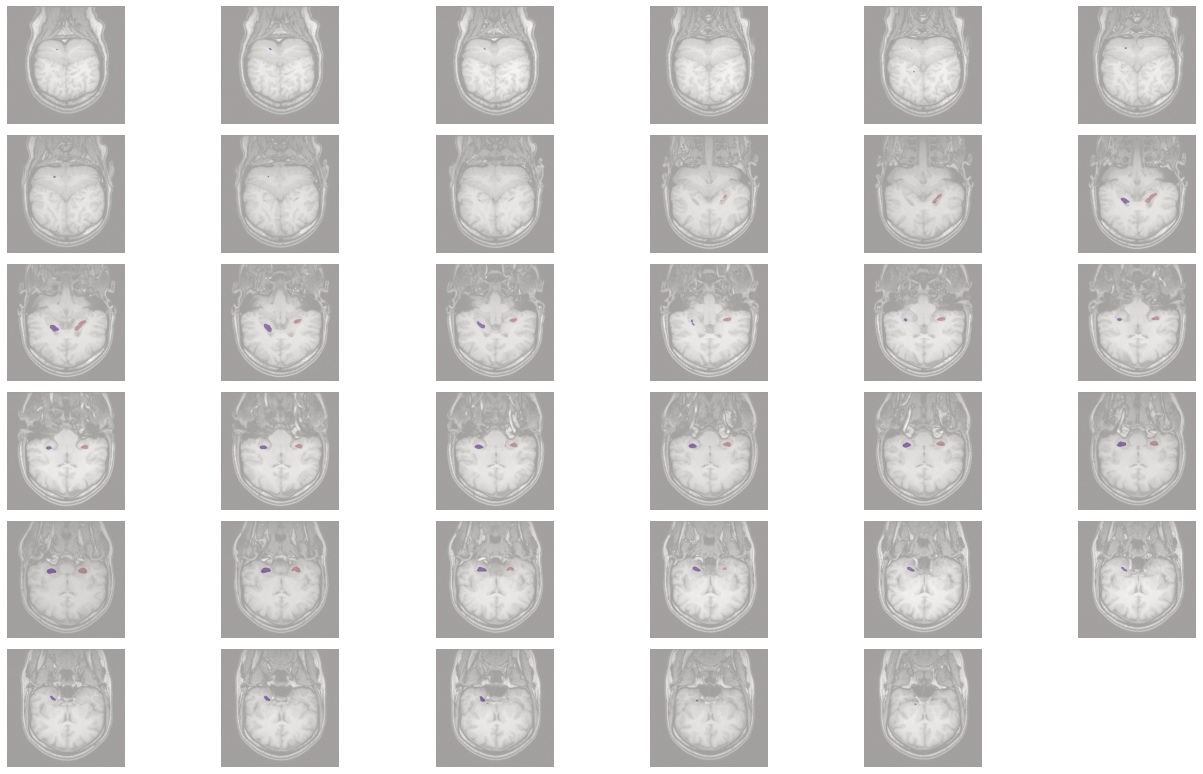

In [102]:
#
#
#   label 있는 것만 predict
#
#
print("40번 환자 img prediction")

index = 1
plt.figure(figsize=(18,18))

for i in range(len(test_img_40)): 
  if np.sum(np.unique(y_pred_img_40[i])) != 0:    
    plt.subplot(10,6,index)
    plt.imshow(test_img_40[i], cmap='gray')
    plt.imshow(y_pred_img_40[i][:,:,0], cmap='Reds', alpha=0.4)
    plt.imshow(y_pred_img_40[i][:,:,1], cmap='Purples', alpha=0.4)
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()


print("40번 환자 hdr prediction")

index = 1
plt.figure(figsize=(18,18))

for i in range(len(test_hdr_40)): 
  if np.sum(np.unique(y_pred_hdr_40[i])) != 0:    
    plt.subplot(10,6,index)
    plt.imshow(test_hdr_40[i], cmap='gray')
    plt.imshow(y_pred_hdr_40[i][:,:,0], cmap='Reds', alpha=0.4)
    plt.imshow(y_pred_hdr_40[i][:,:,1], cmap='Purples', alpha=0.4)
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()   

50번 환자 img prediction


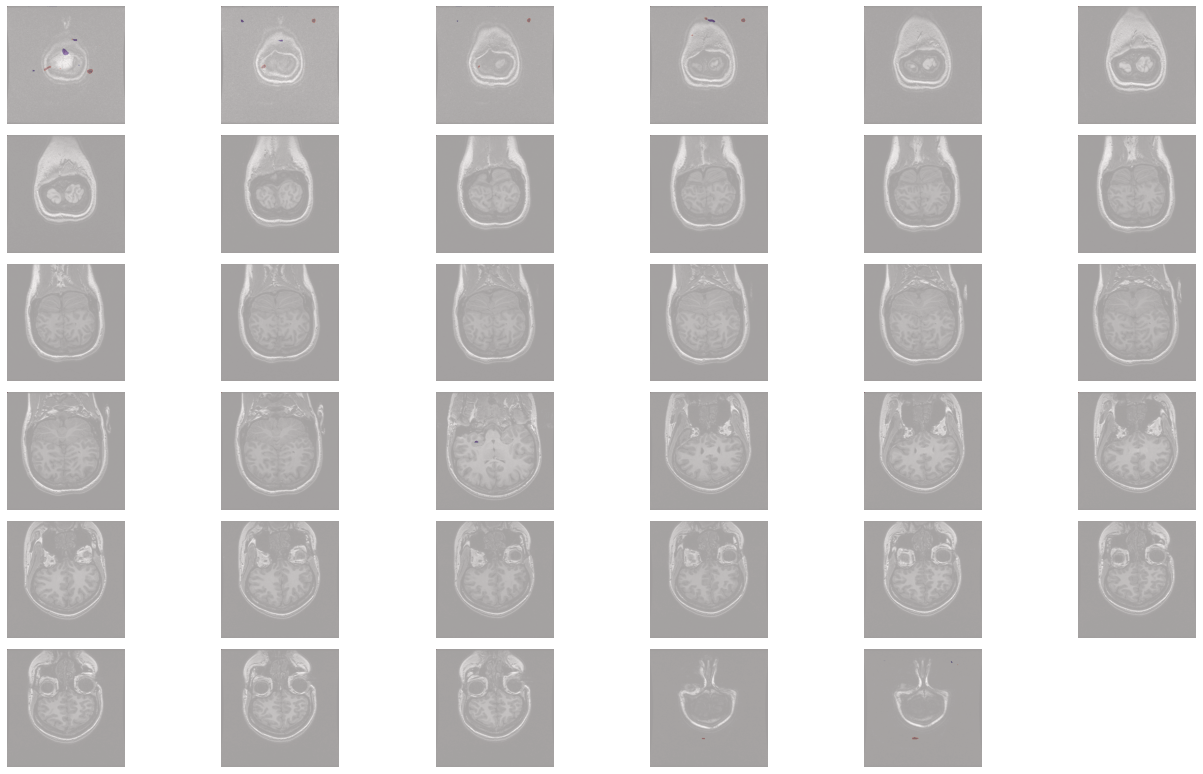

50번 환자 hdr prediction


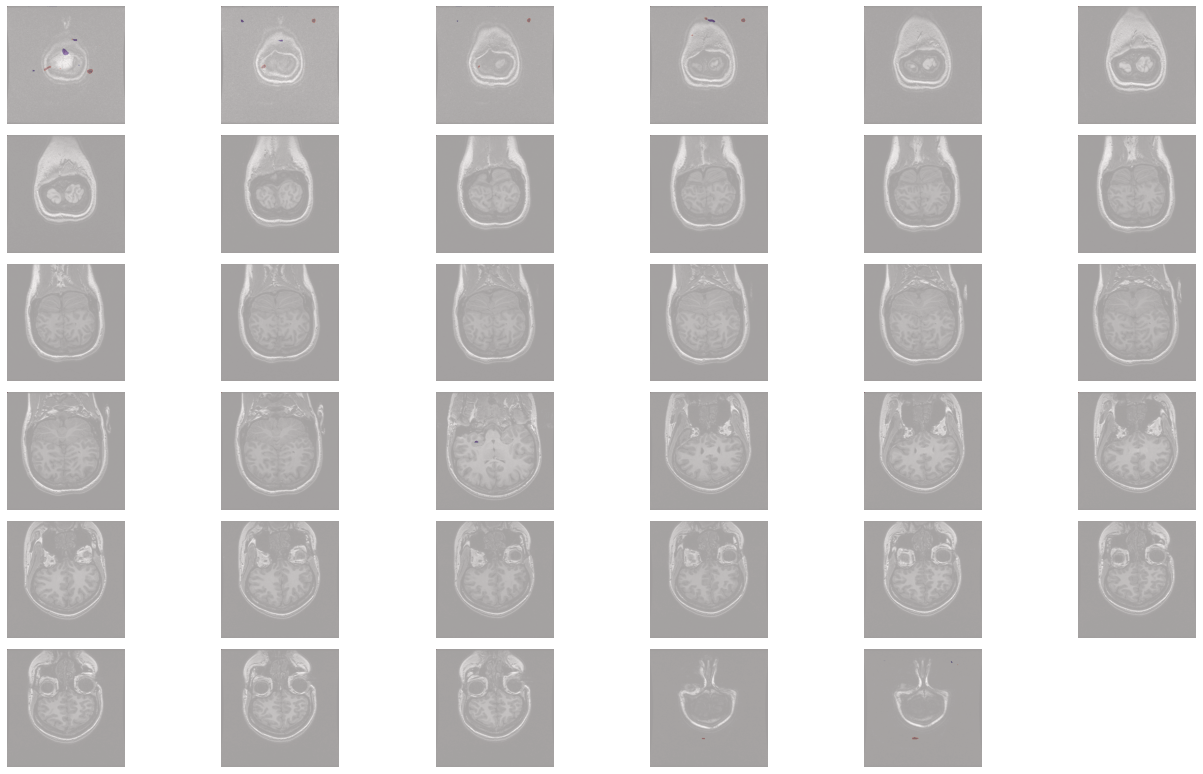

In [103]:
#
#
#   label 있는 것만 predict
#
#
print("50번 환자 img prediction")

index = 1
plt.figure(figsize=(18,18))

for i in range(len(test_img_50)): 
  if np.sum(np.unique(y_pred_img_50[i])) != 0:    
    plt.subplot(10,6,index)
    plt.imshow(test_img_50[i], cmap='gray')
    plt.imshow(y_pred_img_50[i][:,:,0], cmap='Reds', alpha=0.4)
    plt.imshow(y_pred_img_50[i][:,:,1], cmap='Purples', alpha=0.4)
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()


print("50번 환자 hdr prediction")

index = 1
plt.figure(figsize=(18,18))

for i in range(len(test_hdr_50)): 
  if np.sum(np.unique(y_pred_hdr_50[i])) != 0:    
    plt.subplot(10,6,index)
    plt.imshow(test_hdr_50[i], cmap='gray')
    plt.imshow(y_pred_hdr_50[i][:,:,0], cmap='Reds', alpha=0.4)
    plt.imshow(y_pred_hdr_50[i][:,:,1], cmap='Purples', alpha=0.4)
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()   